In [105]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

du = { # thresh=0.1
0.2:[0.574137882739,0.117924053771],
0.4:[0.516598893174,0.0517583826384],
0.8:[0.34328828939,0.0357882812154],
1.2:[0.288284913923,0.0232571237128],
1.6:[0.284424366299,0.0325989118031],
2.0:[0.245942817302,0.0164289592739],
}


0.2: [0.0547305488223,0.000379612285327],
0.4: [0.0586195965431,0.00159756933087],
0.8: [0.0909173363643,0.00561783519452],
1.2: [0.133097579337,0.00612332273824],
1.6: [0.135152551175,0.00808470277998],
2.0: [0.152457332116,0.013546547443],


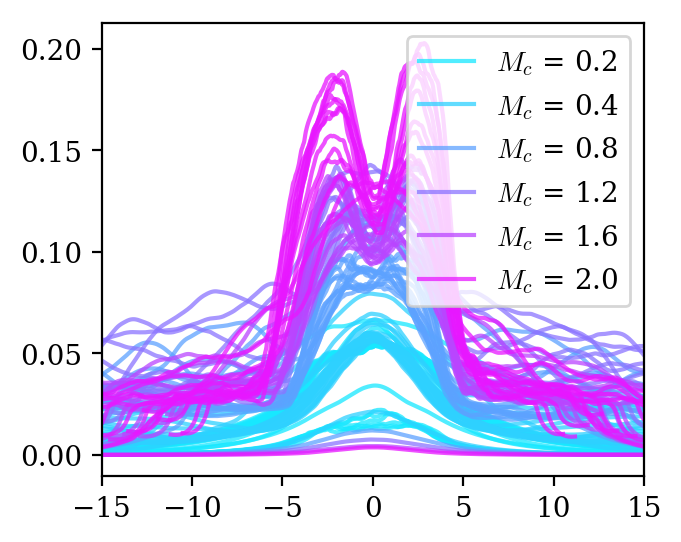

In [108]:
# Scaling using U_delta
s = '1'
# Mc_list = ['08',]#['02','08','20']
Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)


fig = plt.figure(figsize=(3.5,3),dpi=200)
for i,Mc in enumerate(Mc_list):
    if Mc is '04':# or Mc is '02':
        dir_out = '/home/kmatsuno/ShearLayerData/temporal/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    else:
        dir_out = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    directory = dir_out
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    
    tlist,dlist,rates = growth_rates(directory+'shearlayer_')
        
    flist = glob.glob(directory+"rms_thermo*")
    flist.sort()

    if Mc=='02': ist=12;ien=-1;flist=flist[3:] # mira run
    #if Mc=='02': ist=-7;ien=-4 # theta run
    #elif Mc=='04': ist=8;ien=14 #mira run
    elif Mc=='04': ist=13;ien=None #theta run
    elif Mc=='08': ist=7;ien=None
    elif Mc=='12': ist=8;ien=None
    elif Mc=='16': ist=6;ien=None
    elif Mc=='20': ist=2;ien=9
    else: ist=0; ien=None 
        
    colorVal = scalarMap.to_rgba(inp.Mc)
    mat = np.zeros([2,len(flist)])
    for j,fname in enumerate(flist):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)

        # Get dtheta
        idx = np.argmin(abs(tlist-time))
        dtheta = dlist[idx]
        eta = y/dtheta

        # Get rms
        dat = np.fromfile(fname,sep=' ')
        dat = np.reshape(dat,[Ny,2])
        prms = dat[:,1]
        
        # Get utilde and dudy
        scaling='udelta2'
        if scaling=='du2':
            utilde = np.fromfile(directory+'/shearlayer_utilde_%04d.dat'%tID,sep=' ')
            L99,i1,i2 = get_L99(-y,utilde)
            scale = 2./inp.du**2
        elif scaling=='udelta2':
            # Get lscale y
            autocorr = np.fromfile(directory+'/lscale_vv_%04d.dat'%(tID),sep=' ')
            autocorr = np.reshape(autocorr,[Ny,3])
            ly,i1,i2 = get_lscale(y,autocorr[:,0],thresh=0.1)
            scale = 2./(du[inp.Mc][0]*inp.du)**2
            
        fplot = prms*scale 
        if j==0: plt.plot(-eta,fplot,alpha=0.75,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
        else: plt.plot(-eta,fplot,alpha=0.75,color=colorVal)#label='%s'%fname)#
        #mat[j] = abs(1./dtheta * integrate_y(y,fplot))
        mat[0,j] = time*inp.du
        mat[1,j] = abs(max(fplot))
    isort = np.argsort(mat[0,:])
    mat[0,:] = mat[0,isort]
    mat[1,:] = mat[1,isort]
#     plt.plot(mat[0,1:]-mat[0,0],mat[1,1:],'-o',alpha=0.25,color=colorVal)
#     plt.plot(mat[0,ist:ien]-mat[0,0],mat[1,ist:ien],'-o',color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
    print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[1,ist:ien]),np.std(mat[1,ist:ien])))
 
plt.xlim(-15,15)
plt.legend(fontsize=10)

Text(0.5,0.16,'(c)')

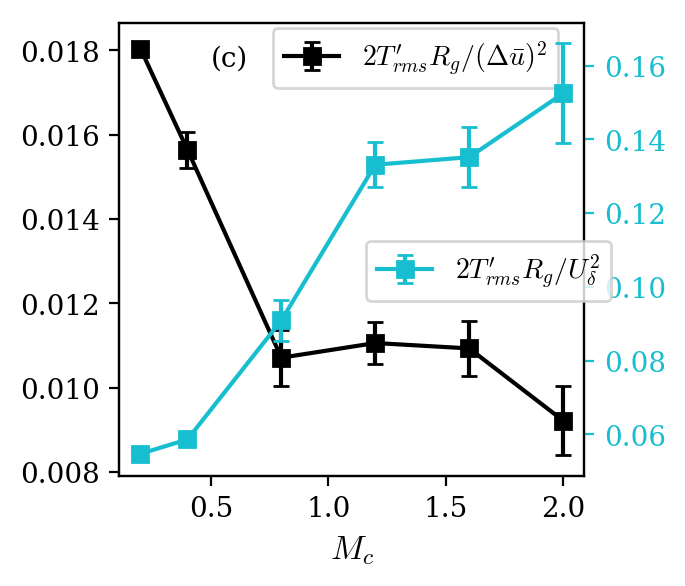

In [104]:
def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

def plotter_v2(ax,dat,fmt,label,colorVal='k'):
    Mcs = []
    vals = []
    errs = []
    for Mc in sorted(dat.keys()):
        Mcs.append( Mc )
        vals.append( dat[Mc][0] )
        errs.append( dat[Mc][1] )
    plt.errorbar(Mcs,vals,color=colorVal,yerr=errs,fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(3,3),dpi=200)
ax = plt.gca()
ax.set_xlabel(r'$M_c$')
plotter_v2(ax,Trms['du2'],'-s',r'$2T^\prime_{rms}R_g/(\Delta\bar{u})^2$')
plt.legend(fontsize=10,bbox_to_anchor=(0.3,1.02))

ax2 = plt.twinx()
plotter_v2(ax2,Trms['udelta2'],'-s',r'$2T^\prime_{rms}R_g/U_\delta^2$',colorVal='C9')
ax2.tick_params(axis='y', labelcolor='C9',color='C9')

plt.legend(fontsize=10,bbox_to_anchor=(0.5,0.55))
plt.annotate('(c)',(0.5,0.16),fontsize=10)

In [71]:
prms = {} # sqrt{\bar{p'*p'}}
prms['du2'] = {
0.2: [0.0731916319543,0.0004617674248],
0.4: [0.0556069904373,0.000373159596251],
0.8: [0.0325536106435,0.0011978571668],
1.2: [0.0242862566385,0.000816990684003],
1.6: [0.019613196653,0.00115878708841],
2.0: [0.01502750335,0.000711585458624],
}
prms['udelta2'] = {
0.2: [0.222038877902,0.00140084758485],
0.4: [0.21442375976,0.00573173465917],
0.8: [0.276236579468,0.0101645243003],
1.2: [0.292224583067,0.00983044713544],
1.6: [0.251242377672,0.0147346904134],
2.0: [0.250188439243,0.0116607357705],
}

Trms = {}
Trms['du2'] = {
0.2: [0.0180410666092,0.000125133233132],
0.4: [0.0156440706187,0.00042635038288],
0.8: [0.0107143216675,0.000662044179428],
1.2: [0.0110614991244,0.000508898279331],
1.6: [0.0109334656855,0.000654029980596],
2.0: [0.00922181919141,0.000819401792313],
} 
Trms['udelta2'] = {
0.2: [0.0547305488223,0.000379612285327],
0.4: [0.0586195965431,0.00159756933087],
0.8: [0.0909173363643,0.00561783519452],
1.2: [0.133097579337,0.00612332273824],
1.6: [0.135152551175,0.00808470277998],
2.0: [0.152457332116,0.013546547443],
}